In [182]:
#!/usr/bin/python3

# IMPORTNAT  this code accept only .fa file as proteome

def parse_oma_db(oma_database_address):
    
    ############### Parsing OMA db ####################
    ###################################################

    oma_db = db.Database(oma_database_address)

    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time, "- OMA data is parsed and its release name is:", oma_db.get_release_name())
    list_oma_speices = [z.uniprot_species_code for z in oma_db.tax.genomes.values()] 
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- There are",len(list_oma_speices),"species in the OMA database.")
    
    return (oma_db, list_oma_speices)


def parse_proteome(list_oma_speices):
    
    ############### Parsing query proteome of species #######
    #########################################################

    
    # IMPORTNAT  this code accept only .fa file as proteome
    project_files = listdir(project_folder+"/omamer_search/proteome/")

    query_species_names = []
    for file in project_files:
        if file.split(".")[-1] == "fa":
            file_name_split = file.split(".")[:-1]
            query_species_names.append('.'.join(file_name_split))
        if file.split(".")[-1] == "fasta":
            file_name_split = file.split(".")[:-1]
            query_species_names.append('.'.join(file_name_split))

    # we may assert existence of query_species_name+".fa/hogmap"
    prots_record_allspecies = [ ]
    for query_species_name in query_species_names:
        prot_address = project_folder +"omamer_search/proteome/"+ query_species_name + ".fa" 
        
        prots_record = list(SeqIO.parse(prot_address, "fasta")) 
        prots_record_allspecies.append(prots_record)

    query_species_num = len(query_species_names)    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- The are",str(query_species_num),"species in the proteome folder.")

    # for development
    for species_i in range(query_species_num):
        len_prot_record_i = len( prots_record_allspecies[species_i] )
        species_name_i = query_species_names[species_i]
        #print(species_name_i,len_prot_record_i)
        if species_name_i in list_oma_speices: 
            current_time = datetime.now().strftime("%H:%M:%S")
            print(current_time,"- the species",species_name_i," already exists in the oma database, remove them first")
            exit()

      
    # The proteins are parsed using  Bio.SeqIO.parse
    # the first part of the header line before space 
    # >tr|A0A2I3FYY2|A0A2I3FYY2_NOMLE Uncharacterized protein OS=Nomascus leucogenys OX=61853 GN=CLPTM1L PE=3 SV=1
    # will be ">tr|A0A2I3FYY2|A0A2I3FYY2_NOMLE"
    # [i.id for i in prots_record_allspecies[0] if len(i.id)!=30 and len(i.id)!=22 ] #'sp|O47892|CYB_NOMLE',
    

    
    return (query_species_names, prots_record_allspecies)


def parse_hogmap_omamer(query_species_names):

    ################### Parsing omamer's output  ########
    #####################################################
    
    prots_hogmap_name_allspecies = []
    prots_hogmap_hogid_allspecies = []
    prots_hogmap_subfscore_allspecies = []
    prots_hogmap_seqlen_allspecies = []
    prots_hogmap_subfmedseqlen_allspecies = []

    for query_species_name in query_species_names:
        omamer_output_address = project_folder + "omamer_search/hogmap/"+ query_species_name + ".hogmap"     
        omamer_output_file = open(omamer_output_address,'r');
        prots_hogmap_name = []
        prots_hogmap_hogid = []
        prots_hogmap_subfscore = []
        prots_hogmap_seqlen = []
        prots_hogmap_subfmedseqlen = []
        
        for line in omamer_output_file:
            line_strip=line.strip()
            if not line_strip.startswith('qs'):
                line_split= line_strip.split("\t")    
                #if line_split[1]!='na':
                prots_hogmap_name.append(line_split[0])
                prots_hogmap_hogid.append(line_split[1])
                prots_hogmap_subfscore.append(line_split[4]) # subfamily
                prots_hogmap_seqlen.append(line_split[5])
                prots_hogmap_subfmedseqlen.append(line_split[6])
                
        prots_hogmap_name_allspecies.append(prots_hogmap_name)
        prots_hogmap_hogid_allspecies.append(prots_hogmap_hogid)
        prots_hogmap_subfscore_allspecies.append(prots_hogmap_subfscore)
        prots_hogmap_seqlen_allspecies.append(prots_hogmap_seqlen)
        prots_hogmap_subfmedseqlen_allspecies.append(prots_hogmap_subfmedseqlen)
    
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- There are ",len(prots_hogmap_name_allspecies)," species in the hogmap folder.")
    print(current_time,"- The first species",query_species_names[0]," contains ",len(prots_hogmap_hogid_allspecies[0])," proteins.")
    print(current_time,"- The first protein of first species is ", prots_hogmap_name_allspecies[0][0])

    hogmap_allspecies = (prots_hogmap_name_allspecies, prots_hogmap_hogid_allspecies, prots_hogmap_subfscore_allspecies, prots_hogmap_seqlen_allspecies, prots_hogmap_subfmedseqlen_allspecies)
    return  hogmap_allspecies
    
    
    
def filter_prot_mapped(query_species_names, query_prot_records_species,query_prot_names_species_mapped):
    # omamer remove very small proteins, 
    # so  we lose track of order comparing hogmap and fasta file
    # the goal here is to remove those from seq record (of the fasta file)
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- Filtering proteins started.")

    query_prot_records_species_filtered=[]
    for species_idx in range(len(query_species_names)):    
        # from fasta file
        query_species_name=query_species_names[species_idx]
        print(query_species_name)
        query_prot_records_species_i = query_prot_records_species[species_idx]
        query_prot_ids_records = [record.id for record in query_prot_records_species_i]

        # from hogmap file
        # without proteins that are not mapped on any hogs
        query_prot_names_species_i = query_prot_names_species_mapped[species_idx]

        if len(query_prot_names_species_i) != len(query_prot_records_species_i):

            query_prot_records_filterd=[]
            for query_prot_name in query_prot_names_species_i:
                if query_prot_name in query_prot_ids_records:
                    prot_record_idx = query_prot_ids_records.index(query_prot_name)
                    prot_record = query_prot_records_species_i[prot_record_idx]
                    query_prot_records_filterd.append(prot_record)
                else:
                    current_time = datetime.now().strftime("%H:%M:%S")                    
                    print(current_time,"- Error",query_species_name, query_prot_name)

            current_time = datetime.now().strftime("%H:%M:%S")        
            print(current_time,"- For the species", query_species_name, ", few proteins were ignored by omamer.")
            print(current_time,"- before filtering: in hogmap", len(query_prot_names_species_i), "in proteome", len(query_prot_records_species_i))
            print(current_time,"- After filtering:  in hogmap", len(query_prot_names_species_i), "in proteome", len(query_prot_records_filterd))            
            

        else:
            query_prot_records_filterd = query_prot_records_species_i

        query_prot_records_species_filtered.append(query_prot_records_filterd)
    current_time = datetime.now().strftime("%H:%M:%S")        
    print(current_time,"- For the rest of species, all proteins were mapped using OMAmer.")

    return query_prot_records_species_filtered


def run_one_msa(seqRecords_queries):
    ############## MSA  ##############
    ##################################
    #current_time = datetime.now().strftime("%H:%M:%S")
    #print(current_time, "- working on new OG with length of ",len(seqRecords_OG_queries))
    
    
    wrapper_mafft = mafft.Mafft(seqRecords_queries,datatype="PROTEIN") 
    # MAfft error: Alphabet 'U' is unknown. -> add --anysymbol argument needed to define in the sourse code
    # workaround sed "s/U/X/g"
    
    wrapper_mafft.options.options['--retree'].set_value(1)


    run_mafft = wrapper_mafft() # it's wrapper  storing the result  and time 
    time_taken_mafft = wrapper_mafft.elapsed_time

    result_mafft = wrapper_mafft.result 
    time_taken_mafft2 = wrapper_mafft.elapsed_time
    
    current_time = datetime.now().strftime("%H:%M:%S")
    #print(current_time,"- time elapsed for MSA: ",time_taken_mafft2)
    print(current_time,"- MSA for an OG is just finished: ",time_taken_mafft2)

    return(result_mafft)





def draw_tree(msa, tree_out_file):
    ############## Tree inference  ###################
    ##################################################

    wrapper_tree=fasttree.Fasttree(msa,datatype="PROTEIN")
    wrapper_tree.options.options['-fastest']    
    result_tree1 = wrapper_tree()

    time_taken_tree = wrapper_tree.elapsed_time 
    time_taken_tree

    result_tree2 = wrapper_tree.result
    tree_nwk=str(result_tree2["tree"])
    current_time = datetime.now().strftime("%H:%M:%S")
    print(current_time,"- ",len(tree_nwk))

    #out_name_tree=project_folder+"fastoma_core/_tree.txt"
    file1 = open(tree_out_file,"w")
    file1.write(tree_nwk)
    file1.write(";\n")
    
    file1.close() 
    return tree_nwk



def merge_msa(list_msas):
    # each element of msa should be  a MultipleSeqAlignment
    wrapper_mafft_merge = mafft.Mafft(list_msas, datatype="PROTEIN") 
    wrapper_mafft_merge.options['--merge'].active = True
    merged = wrapper_mafft_merge()
    
    
    print(len(list_msas),"msas are merged into one with the length of ",len(merged),len(merged[0]) )
    return merged




    
    
def compact_distance_matrix_tree(tree_input):

    # tree_input   in ete3 format
    # output  a vector upper triangulare 
    
    tree_leaves=[]
    for node in tree_input.traverse(strategy="postorder"):
        if node.is_leaf() : 
            node_name = node.name
            tree_leaves.append(node_name)


    leaves_num = len(tree_leaves)
    distance_matrix = np.zeros([leaves_num,leaves_num])

    for i in range(leaves_num):
        for j in range(leaves_num):
            if i < j:
                value= round(tree_input.get_distance(tree_leaves[i],tree_leaves[j]),3)
                distance_matrix[i][j]= value
                distance_matrix[j][i]= value

    y=[]
    for i in range(len(distance_matrix)):
        for j in range(len(distance_matrix)):
            if i<j:
                val= distance_matrix[i][j]
                y.append(val)
    return (y,tree_leaves)

    

from scipy.cluster.hierarchy import dendrogram, linkage, ward, leaves_list, fcluster

from ete3 import Tree

import numpy as np
import pyoma.browser.db as db
import concurrent.futures
import ast
import pickle

from pyoma.browser.models import ProteinEntry

#import zoo
#zoo.__file__

import zoo.wrappers.aligners.mafft as mafft  # mafft should be installed beforehand
import zoo.wrappers.treebuilders.fasttree as fasttree

from datetime import datetime
from sys import argv
from os import listdir
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq, UnknownSeq
from Bio.Align import MultipleSeqAlignment

from collections import defaultdict


import matplotlib   #for development 
#matplotlib.use('Agg')
import matplotlib.pyplot as plt


import pyoma.browser.db as db
from pyoma.browser.hoghelper import build_hog_to_og_map


import time

In [4]:


# if __name__ == "__main__":

    
#     # a global variable
#     #project_folder = argv[1]
#     project_folder = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastget/v1a/"
    
#     oma_database_address = project_folder+"omamer_database/oma_path/OmaServer.h5"
    
#     print("program has started. The oma database address is in ",oma_database_address)
    
#     (oma_db, list_oma_speices) = parse_oma_db(oma_database_address)

     
#     (query_species_names, query_prot_records_species) = parse_proteome(list_oma_speices)   
    
#     hogmap_allspecies = parse_hogmap_omamer(query_species_names)
    
#     (query_prot_names_species_mapped, prots_hogmap_hogid_allspecies, prots_hogmap_subfscore_allspecies, prots_hogmap_seqlen_allspecies, prots_hogmap_subfmedseqlen_allspecies) = hogmap_allspecies 

#     query_prot_records_species_filtered =  filter_prot_mapped(query_species_names, query_prot_records_species, query_prot_names_species_mapped)

#     print(len(query_prot_records_species_filtered),len(query_prot_records_species_filtered[0]))
    


## Write  rootHoGs as fasta file

In [ ]:

# prots_hogmap_rhogid_allspecies = []
# for prots_hogmap_hogid in prots_hogmap_hogid_allspecies:
#     prots_hogmap_rhogid = []
#     for prot_hogmap_hogid in prots_hogmap_hogid:
#         prot_hogmap_rhogid=prot_hogmap_hogid.split(".")[0]
#         prots_hogmap_rhogid.append(prot_hogmap_rhogid)
        
#     prots_hogmap_rhogid_allspecies.append(prots_hogmap_rhogid)

    
    
# rhogid_prot_idx_dic = {}

# for species_idx in range(len(query_species_names)):
    
#     species_name = query_species_names[species_idx]
    
#     prots_hogmap_rhogid = prots_hogmap_rhogid_allspecies[species_idx]
    
#     for prots_hogmap_idx in range(len(prots_hogmap_rhogid)):
        
#         prot_hogmap_rhogid = prots_hogmap_rhogid[prots_hogmap_idx]
        
#         if prot_hogmap_rhogid in rhogid_prot_idx_dic:
#             rhogid_prot_idx_dic[prot_hogmap_rhogid].append((species_idx,prots_hogmap_idx))
#         else:
#             rhogid_prot_idx_dic[prot_hogmap_rhogid] = [(species_idx,prots_hogmap_idx)]
            
            
            
# print(len(rhogid_prot_idx_dic), rhogid_prot_idx_dic['HOG:0018405'])


# rhogids_prot_records_query = [ ]

# rhogids_list = []
# for rhogid in rhogid_prot_idx_dic.keys() :
    
#     if rhogid != "na" and len(rhogid)>1:
#         rhogids_list.append(rhogid)
#         rhogid_prot_idx =  rhogid_prot_idx_dic[rhogid]
#         rhogid_prot_records = []
#         for (species_idx, prots_hogmap_idx) in rhogid_prot_idx:
#             prot_record = query_prot_records_species_filtered[species_idx][prots_hogmap_idx] 
#             #print(prot_record)
#             rhogid_prot_records.append(prot_record)
     
    
#     rhogids_prot_records_query.append(rhogid_prot_records)
    
    
    
# print(len(rhogids_prot_records_query),len(rhogids_prot_records_query[0]))

In [ ]:

# rhogids_prot_records = []

# for rhogid_idx in range(len(rhogids_list)):
    
#     rhogid_prot_records_query= rhogids_prot_records_query[rhogid_idx] 

#     rhogid = rhogids_list[rhogid_idx]

    
#     rhogid_num= int(rhogid.split(":")[1])
#     rhogids_prot_records_oma = []
#     for hog_elements in oma_db.member_of_fam(rhogid_num):   # this gets the member of roothog 2 (HOG:000002)
#         prot_hog_element = ProteinEntry(oma_db, hog_elements)
#         #print(prot_hog_element.omaid, prot_hog_element.hog_family_nr, len(prot_hog_element.sequence),prot_hog_element.sequence[0])
        
#         rhogids_prot_records_oma.append(SeqRecord(Seq(prot_hog_element.sequence), id=prot_hog_element.omaid))
#     rhogids_prot_records.append(rhogids_prot_records_oma +  rhogid_prot_records_query)
    
# print(len(rhogids_prot_records), len(rhogids_prot_records[0]))

# address_out_hog="/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastget/v1a/hog_out/"
# # mkdir hog_out


# for rhogid_idx in range(len(rhogids_list)):
    
#     rhogid_prot_records= rhogids_prot_records[rhogid_idx] 

#     rhogid = rhogids_list[rhogid_idx]

#     SeqIO.write(rhogid_prot_records, address_out_hog+"HOG_"+str(int(rhogid.split(":")[1]))+".fa", "fasta")
    
# print("Each of ",len(rhogids_list),"hogs were written into separat fasta file.")    
    

## now consider only one rHOG (including   omaDB+query proteins )

In [12]:
address_working_folder = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastget/v1a/"

address_out_hog= address_working_folder+ "hog_out/"

prot_address=address_out_hog+"HOG_"+str(10019)+".fa"
rhog_i= list(SeqIO.parse(prot_address, "fasta")) 
print("number of proteins in the rHOG", len(rhog_i))

id_list=[]
for rec in rhog_i:
    id_list.append(rec.id)
species_names = [i[:5] for i in id_list]
species_names_uniqe = set(species_names)
print("number of unique species in the rHOG",len(species_names_uniqe))

number of proteins in the rHOG 39
number of unique species in the rHOG 24


## read species tree

In [23]:
import os
# import numpy as np
# from sys import argv
# from datetime import datetime
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
import ete3


fast_tree_address = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/primate_oma/v27_10/fastoma_core_splice_subf0.5/"
fast_tree_address += "_100_msa_concatanated.txt.contree"+"_collapsed__94_0.001"


print(fast_tree_address)
print(round(os.path.getsize(fast_tree_address)/1000),"kb")

fast_tree= ete3.Tree(fast_tree_address) # ,format=0
print("length of tree is ",len(fast_tree))

/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/primate_oma/v27_10/fastoma_core_splice_subf0.5/_100_msa_concatanated.txt.contree_collapsed__94_0.001
1 kb
length of tree is  35


In [4]:
species_tree_leaves=[]
for node in fast_tree.traverse(strategy="postorder"):
    if node.is_leaf() : 
        node_name = node.name
        species_tree_leaves.append(node_name)

species_tree_leaves_uniq = [i for i in species_tree_leaves if i[-1]!='_']
print(len(species_tree_leaves_uniq), len(species_tree_leaves),species_tree_leaves_uniq)



fast_tree.prune(species_tree_leaves_uniq)
#print(fast_tree)
fast_tree.write()

25 35 ['COLAP', 'BOVIN', 'MOUSE', 'OTOGA', 'MICMU', 'PROCO', 'CARSF', 'SAIBB', 'CALJA', 'AOTNA', 'GORGO', 'PANTR', 'PANPA', 'HUMAN', 'PONAB', 'NOMLE', 'MACNE', 'MACFA', 'MANLE', 'CERAT', 'CHLSB', 'PAPAN', 'MACMU', 'RHIBE', 'RHIRO']


'(COLAP:0.00172937,((((((BOVIN:0.00223615,MOUSE:0.000391497)100:0.0146723,((MICMU:0.0371289,PROCO:0.0265011)100:0.013476,OTOGA:2.62966e-05)100:0.0155775,CARSF:2.7073e-06)100:0.0248855,((CALJA:0.0366017,SAIBB:0.00218759)97:0.00151199,AOTNA:0.0532771)100:0.0142606)100:0.00783661,((((PANPA:0.0230622,PANTR:0.00122899)100:0.00168806,HUMAN:0.0110641,GORGO:0.0012583)100:0.00274361,PONAB:0.015492)100:0.00131714,NOMLE:0.0382361)100:0.00531884)100:0.0116669,(MACFA:0.0163475,MACNE:0.0022106)96:0.00197187,CERAT:0.0245506,(CHLSB:0.0107976,PAPAN:0.0131583)96:0.00203856,MACMU:0.046456,MANLE:0.000396765)100:0.00319826,(RHIBE:0.013633,RHIRO:0.00265876)100:0.0153811)100:0.0108101);'

In [5]:
# species_tree_leaves=[]
# for node in fast_tree.traverse(strategy="postorder"):
#     if node.is_leaf() : 
#         node_name = node.name
#         species_tree_leaves.append(node_name)

# species_tree_leaves_uniq = [i for i in species_tree_leaves if i[-1]!='_']
# print(len(species_tree_leaves_uniq), len(species_tree_leaves),species_tree_leaves_uniq)


fast_tree.prune(['PANPA', 'PANTR', 'BOVIN', 'MOUSE']) # 'HUMAN', 'GORGO'
print(fast_tree)

        #print(no_list)
#"PNAB"   ("GORGO"  "HUMAN")


      /-BOVIN
   /-|
  |   \-MOUSE
--|
  |   /-PANPA
   \-|
      \-PANTR


In [6]:
fast_tree.write()

'((BOVIN:0.00223615,MOUSE:0.000391497)100:0.0146723,(PANPA:0.0230622,PANTR:0.00122899)100:0.00168806);'

##  BOVIN & MOUSE

In [183]:
node_species_name = "BOVIN"
intrest_list_1 = [idx  for idx in range(len(species_names)) if species_names[idx] == node_species_name ]
print("indeces of proteins in rHOG corresponding to species ",node_species_name,":",intrest_list_1)
 
node_species_name = "MOUSE"
intrest_list_2 = [idx  for idx in range(len(species_names)) if species_names[idx] == node_species_name ]
print("indeces of proteins in rHOG corresponding to species ",node_species_name,":",intrest_list_2)



# seq records of each species in this rHOG
rhog_i_1 = [rhog_i[i] for i in intrest_list_1]
rhog_i_2 = [rhog_i[i] for i in intrest_list_2]


# run MSA on each 
sub_msa_1 = run_one_msa(rhog_i_1)
sub_msa_2 = run_one_msa(rhog_i_2)
time.sleep(3) 

seq_id_both = [i.id for i in rhog_i_1]+ [i.id for i in rhog_i_2]
print(seq_id_both)




merged_msa_1 = merge_msa([sub_msa_1,sub_msa_2]) 


tree_out_file = address_working_folder +"out1.nwk"
tree_out_raw = draw_tree(merged_msa_1, tree_out_file)
print(tree_out_raw)

tree_out = Tree(tree_out_raw+";", format=0)
print(tree_out)
print("length of tree is ",len(tree_out))

(y,tree_leaves) = compact_distance_matrix_tree(tree_out)

print(len(y))



indeces of proteins in rHOG corresponding to species  BOVIN : [0, 19, 20]
indeces of proteins in rHOG corresponding to species  MOUSE : [5, 6, 21]
13:57:35 - MSA for an OG is just finished:  0.3287992477416992
13:57:35 - MSA for an OG is just finished:  0.18489670753479004
['BOVIN09898', 'BOVIN09896', 'BOVIN09897', 'MOUSE01292', 'MOUSE01293', 'MOUSE44014']
2 msas are merged into one with the length of  6 666
13:57:39 -  175
(BOVIN09898:0.088984372,((BOVIN09896:0.0,BOVIN09897:0.0):0.074374249,MOUSE44014:0.070091173)1.000:0.167813492,(MOUSE01292:0.147998218,MOUSE01293:0.181646904)0.915:0.041841267)

   /-BOVIN09898
  |
  |      /-BOVIN09896
  |   /-|
--|--|   \-BOVIN09897
  |  |
  |   \-MOUSE44014
  |
  |   /-MOUSE01292
   \-|
      \-MOUSE01293
length of tree is  6
15


In [116]:

Z = linkage(y, 'ward') # ward  single
# print(Z)
# fig = plt.figure(figsize=(25, 10))
#dn = dendrogram(Z) # ,color_threshold=.02
# plt.save(+"a.")
#print(dn)

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster
    
clusters_1 = fcluster(Z,0.7*max(Z[:,2]), criterion='distance') 

print(clusters_1)
#

sub_msas_1 = []
for cluster_id in range(1,max(clusters_1)+1):
    sub_msa = [  merged_msa_1[int(i)]   for i in list(np.where(clusters_1==cluster_id)[0])   ]
    sub_msas_1.append(sub_msa)
    
print(len(sub_msas_1))    

[3 1 1 2 3 4]
4


In [117]:
    


# print(clusters_1)

# for cluster_id in range(1,max(clusters_1)+1):
#     print("*cluster",cluster_id,":")
#     for i in range(len(clusters_1)):

#         if cluster_id == clusters_1[i]:
#             print(tree_leaves[i])
            
# # X= distance_matrix 


# cluster1_idx = [1,2,3]
# cluster2_idx = [0,4,5]


## PANPA & PANPAB

In [118]:
node_species_name = "PANPA"
intrest_list_1 = [idx  for idx in range(len(species_names)) if species_names[idx] == node_species_name ]
print("indeces of proteins in rHOG corresponding to species ",node_species_name,":",intrest_list_1)
 
node_species_name = "PANTR"
intrest_list_2 = [idx  for idx in range(len(species_names)) if species_names[idx] == node_species_name ]
print("indeces of proteins in rHOG corresponding to species ",node_species_name,":",intrest_list_2)
    
file_suffix="ar"

    
# seq records of each species in this rHOG
rhog_i_1 = [rhog_i[i] for i in intrest_list_1]
rhog_i_2 = [rhog_i[i] for i in intrest_list_2]









# run MSA on each 
sub_msa_1 = run_one_msa(rhog_i_1)
sub_msa_2 = run_one_msa(rhog_i_2)
time.sleep(3) 

seq_id_both = [i.id for i in rhog_i_1]+ [i.id for i in rhog_i_2]
print(seq_id_both)




merged_msa_2 = merge_msa([sub_msa_1,sub_msa_2]) 


tree_out_file = address_working_folder +"out1.nwk"
tree_out_raw = draw_tree(merged_msa_2, tree_out_file)
print(tree_out_raw)

tree_out = Tree(tree_out_raw+";", format=0)
print(tree_out)
print("length of tree is ",len(tree_out))

(y,tree_leaves) = compact_distance_matrix_tree(tree_out)

print(len(y))





indeces of proteins in rHOG corresponding to species  PANPA : [18]
indeces of proteins in rHOG corresponding to species  PANTR : [9, 26]
12:08:29 - MSA for an OG is just finished:  0.12518000602722168
12:08:29 - MSA for an OG is just finished:  0.1308450698852539
['PANPA23689', 'PANTR26412', 'PANTR26407']
12:08:32 -  68
((PANPA23689:0.0,PANTR26407:0.0):0.186998492,PANTR26412:0.186998492)

      /-PANPA23689
   /-|
--|   \-PANTR26407
  |
   \-PANTR26412
length of tree is  3
3


In [142]:

Z = linkage(y, 'ward') # ward  single
# print(Z)
# fig = plt.figure(figsize=(25, 10))
#dn = dendrogram(Z) # ,color_threshold=.02
# plt.save(+"a.")
#print(dn)

clusters_2 = fcluster(Z,0.7*max(Z[:,2]), criterion='distance')
print(clusters_2)
#

sub_msas_2 = []
for cluster_id in range(1,max(clusters_2)+1):
    sub_msa = [  merged_msa_2[int(i)]   for i in list(np.where(clusters_2==cluster_id)[0])   ]
    sub_msas_2.append(sub_msa)
    
print(len(sub_msas_2))    

[1 1 2]
2


In [120]:
 
    
# from scipy.cluster.hierarchy import dendrogram, linkage, ward, leaves_list, fcluster

# Z = linkage(y, 'ward') # ward  single
# print(Z)

# fig = plt.figure(figsize=(25, 10))
# dn = dendrogram(Z) # ,color_threshold=.02
# print(dn)
# plt.show()

   
# #X= distance_matrix




## PANPA & PANPTR    &    BOVIN & MOUSE


In [143]:
# for i in sub_msas_raw_all[0]:
#     print(len(i))

sub_msas_raw_all = sub_msas_2+ sub_msas_1

print(len(sub_msas_raw_all))

# not sure this step is needed, since all of them are sub msa
sub_msas_all = [ ]
for sub_msa_raw in sub_msas_raw_all:
    sub_msa = run_one_msa(sub_msa_raw)
    sub_msas_all.append(sub_msa)

merged_msa_3 = merge_msa(sub_msas_all) 

  
# for i in merged_msa_3:
#     print(i.id)

6
13:35:33 - MSA for an OG is just finished:  0.2687819004058838
13:35:33 - MSA for an OG is just finished:  0.10682272911071777
13:35:34 - MSA for an OG is just finished:  0.11521649360656738
13:35:34 - MSA for an OG is just finished:  0.11478829383850098
13:35:34 - MSA for an OG is just finished:  0.12043046951293945
13:35:34 - MSA for an OG is just finished:  0.1071171760559082
6 msas are merged into one with the length of  9 666


In [184]:

tree_out_file = address_working_folder +"out3.nwk"
tree_out_raw = draw_tree(merged_msa_3, tree_out_file)
print(tree_out_raw)



tree_out = Tree(tree_out_raw+";", format=0)
print(tree_out)
print("length of tree is ",len(tree_out))

(y,tree_leaves) = compact_distance_matrix_tree(tree_out)

print(len(y))



13:57:44 -  294
(BOVIN09898:0.082433333,(MOUSE44014:0.047504363,((BOVIN09896:0.0,BOVIN09897:0.0):0.078463302,(PANPA23689:5e-09,PANTR26407:0.001560724)1.000:0.08201573)0.634:0.014898016)1.000:0.195349127,(MOUSE01292:0.179282666,(PANTR26412:0.105547167,MOUSE01293:0.164425573)0.852:0.033076758)0.746:0.038023123)

   /-BOVIN09898
  |
  |   /-MOUSE44014
  |  |
  |--|      /-BOVIN09896
  |  |   /-|
--|  |  |   \-BOVIN09897
  |   \-|
  |     |   /-PANPA23689
  |      \-|
  |         \-PANTR26407
  |
  |   /-MOUSE01292
   \-|
     |   /-PANTR26412
      \-|
         \-MOUSE01293
length of tree is  9
36


[[2.00000000e+00 3.00000000e+00 0.00000000e+00 2.00000000e+00]
 [4.00000000e+00 5.00000000e+00 2.00000000e-03 2.00000000e+00]
 [1.00000000e+00 9.00000000e+00 1.62812776e-01 3.00000000e+00]
 [1.00000000e+01 1.10000000e+01 2.18381318e-01 5.00000000e+00]
 [0.00000000e+00 7.00000000e+00 2.59000000e-01 2.00000000e+00]
 [8.00000000e+00 1.30000000e+01 3.06032133e-01 3.00000000e+00]
 [6.00000000e+00 1.40000000e+01 3.55587308e-01 4.00000000e+00]
 [1.20000000e+01 1.50000000e+01 8.72725068e-01 9.00000000e+00]]


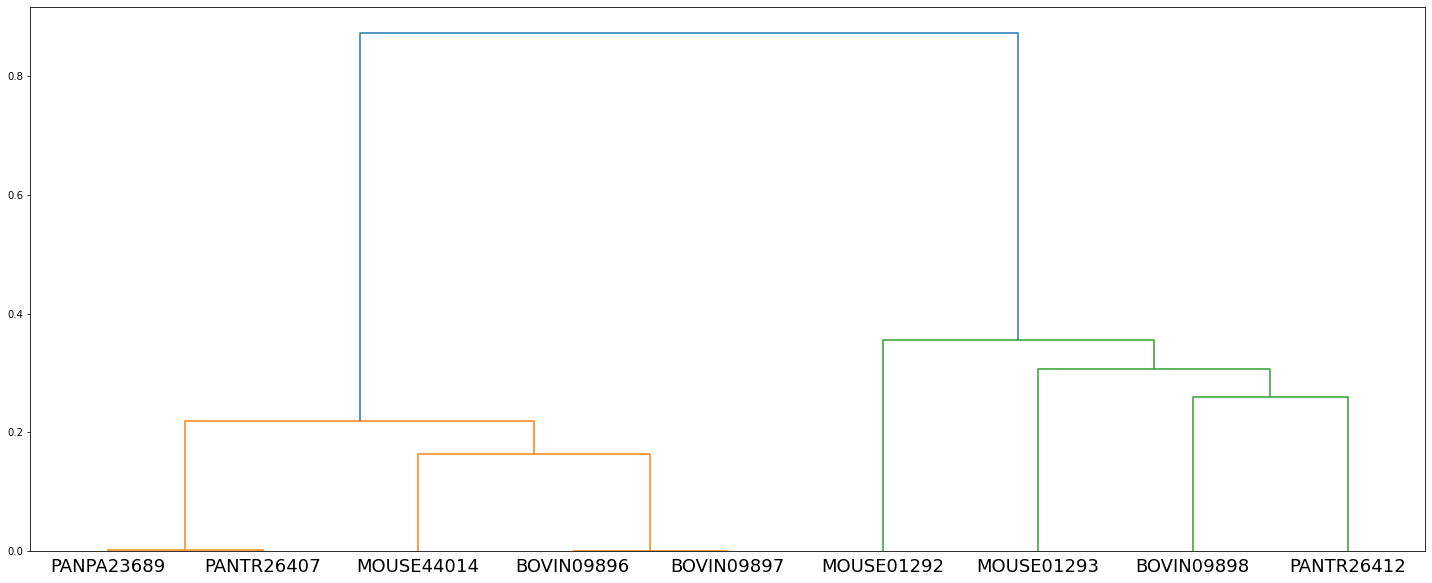

In [200]:

Z = linkage(y, 'ward') # ward  single
print(Z)
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z, color_threshold = 0.7*max(Z[:,2]), labels=tree_leaves, leaf_font_size=18, leaf_rotation=0) # is defualt color_threshold= 0.7*max(Z[:,2]). 

# plt.save(+"a.")
#print(dn)


# 




In [153]:
max(Z[:,2])

0.8727250680738146

In [192]:
0.9* max(Z[:,2])

0.7854525612664331

In [201]:

clusters_3 = fcluster(Z, 0.7* max(Z[:,2]), criterion='distance') # this treshold does not correspond to dendogram
print(clusters_3,"\n",tree_leaves)



[2 1 1 1 1 1 2 2 2] 
 ['BOVIN09898', 'MOUSE44014', 'BOVIN09896', 'BOVIN09897', 'PANPA23689', 'PANTR26407', 'MOUSE01292', 'PANTR26412', 'MOUSE01293']


In [ ]:

#

sub_msas_3 = []
for cluster_id in range(1,max(clusters_3)+1):
    sub_msa = [  merged_msa_3[int(i)]   for i in list(np.where(clusters_3==cluster_id)[0])   ]
    sub_msas_3.append(sub_msa)
    
print(len(sub_msas_3))    


In [ ]:

   /-MOUSE01292
  |
  |   /-MOUSE44014
  |  |
  |--|      /-BOVIN09896
  |  |   /-|
--|  |  |   \-BOVIN09897
  |   \-|
  |     |   /-PANPA23689
  |      \-|
  |         \-PANTR26407
  |
  |   /-BOVIN09898
   \-|
     |   /-MOUSE01293
      \-|
         \-PANTR26412